## gml-extent-maker

* Dataset
     * HI.x833.000.0009 - 2-meter Topographic Lidar Digital Elevation Model (DEM) of the Upper Texas Coast, 2015-02-02 to 2019-01-29
* Source data
     * shapefile polygon of DEM footprint, nodata cells not included


In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob, os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from osgeo import osr
#from osgeo import ogr
from tqdm import tqdm
from geopandas import GeoDataFrame
from shapely import geometry
#from shapely.geometry import box, mapping, Point, LineString, Polygon, MultiPoint, MultiPolygon
from shapely.geometry import Point
from geomEngine import *
from gmlEngine import get_rounded_geom, gmlReplacer
from concave_hull import alpha_shape_vector

import inspect
output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [11]:
gdf = gpd.read_file('./data/EV_TOPO_LowerTexasCoastDEM_2m_HRI_2021.shp')
print(gdf.crs)
print(len_geom(gdf.geometry[0]))
gdf

epsg:26914
(2579059, 'coords', 153, 'geoms', 'MultiPolygon')


,OID_,Shape_Leng,Shape_Area,geometry
0,0,6178240.0,2.218878e+10,MULTIPOLYGON Z (((676235.000 3057135.000 0.317...


<AxesSubplot:>

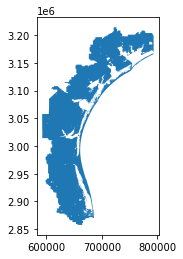

In [12]:
gdf.plot()

In [23]:
%%time
simp_gdf = gdf.copy()
simp_gdf['geometry'] = gdf.geometry.simplify(100)
print(len_geom(simp_gdf.geometry[0]))

(4254, 'coords', 153, 'geoms', 'MultiPolygon')
Wall time: 6.7 s


<AxesSubplot:>

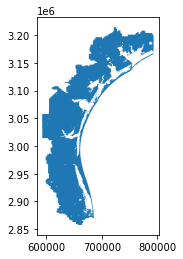

In [14]:
simp_gdf.plot()

EPSG:4326


<AxesSubplot:>

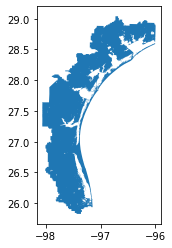

In [15]:
simp_gdf_wgs84 = simp_gdf.to_crs("EPSG:4326")
print(simp_gdf_wgs84.crs)
simp_gdf_wgs84.plot()

In [16]:
# Get all coords into pointList to feed to concave hull
g = simp_gdf_wgs84.geometry[0]
pointList = []
for poly in tqdm(g.geoms):
    for pt in poly.exterior.coords:
        x = pt[0]
        y = pt[1]
        newPoint = Point(x,y)
        pointList.append(newPoint)
print(len(pointList))
print(pointList[0])

100%|██████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 6374.89it/s]

4254
POINT (-97.21386519338114 27.62678844432084)


(143, 'coords', 1, 'geoms', 'Polygon')


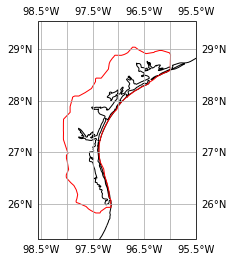

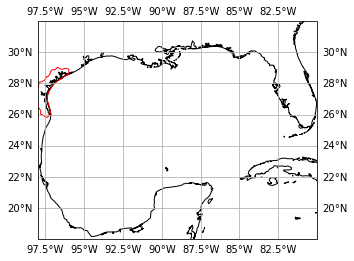

Wall time: 705 ms


In [20]:
%%time
# Concave Hull

alpha = 6
concave_hull, edge_points = alpha_shape_vector(pointList, alpha=alpha)
print(len_geom(concave_hull))
plot_geoms(concave_hull)

In [22]:
newgml = gmlMaker(get_rounded_geom(concave_hull))
gmlReplacer(newgml,"extent-metadata.xml")